In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm as tqdm_nb 
import warnings


In [2]:
# --- Configuration ---
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid') 

# --- Parameters ---
DATA_PATH = 'synthetic_tashkent_aq_2023_2024_cleaned.csv' 
DATETIME_COL = 'datetime'
LAT_COL = 'latitude'
LON_COL = 'longitude'
TARGET_COL = 'PM2.5'
TIME_FEATURES_EXTRACTED = ['hour', 'day', 'month', 'year']

# Feature Engineering Params
N_LAGS = 5 # Number of hourly lags for pm2_5
ROLLING_WINDOWS = [3, 6, 12] # Hourly rolling windows for pm2_5
N_CLUSTERS = 10 # Number of spatial clusters (tune based on data)

# Splitting Params
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15 

# Model Params
# LightGBM
LGBM_PARAMS = {
    'objective': 'regression_l1', # MAE
    'metric': 'mae',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}
LGBM_EARLY_STOPPING_ROUNDS = 50

# XGB parameters
XGB_PARAMS = {
    'objective': 'reg:squarederror',   # Use squared error for RMSE optimization
    'eval_metric': 'mae',              

    'n_estimators': 950,              
    'learning_rate': 0.01,             

    'max_depth': 8,                   
    'min_child_weight': 3,             

    'subsample': 0.8,                
    'colsample_bytree': 0.8,           

    'gamma': 1.0,                      

    'lambda': 1.0,                     # L2 regularization (Ridge)
    'alpha': 0.1,                      # L1 regularization (Lasso)

    'tree_method': 'hist',             # Faster on large datasets
    'grow_policy': 'lossguide',        # For deeper trees that focus on loss minimization

    'n_jobs': -1,                      # Parallelize training
    'verbosity': 0,                    # Suppress output
    'seed': 42,                        # Reproducibility
    'enable_categorical': True        # Enable categorical features
}

XGB_EARLY_STOPPING_ROUNDS = 50

XGB_EARLY_STOPPING_ROUNDS = 50


# LSTM (Deep Learning)
SEQ_LENGTH = 24 # Use last 24 hours of data to predict the next hour
LSTM_HIDDEN_SIZE = 64
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.2
LSTM_BATCH_SIZE = 128
LSTM_EPOCHS = 10 # Adjust based on convergence
LSTM_LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'




In [3]:
# --- 1. Data Loading and Initial Preparation ---

def load_data(filepath, dt_col):
    """Loads data and parses datetime column."""
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath)
        df[dt_col] = pd.to_datetime(df[dt_col])
        print("Data loaded successfully.")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        required_cols = [LAT_COL, LON_COL, dt_col, TARGET_COL] + TIME_FEATURES_EXTRACTED
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")
        return df
    except FileNotFoundError:
        print(f"Error: Data file not found at {filepath}")
        raise
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def cyclical_encode(df, col, max_val):
    """Encodes temporal features cyclically using sin/cos."""
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

def feature_engineer(df, dt_col, target_col, lat_col, lon_col, lags, windows, n_clusters):
    """Engineers temporal and spatial features."""
    print("Starting feature engineering...")
    df = df.sort_values(by=[lat_col, lon_col, dt_col])
    # --- Temporal Features ---
    print("  Encoding cyclical time features...")
    df = cyclical_encode(df, 'hour', 23.0)
    df = cyclical_encode(df, 'day', 31.0)
    df = cyclical_encode(df, 'month', 12.0)

    print("  Generating temporal lags and rolling features...")
    # Create a temporary station ID for grouping
    df['station_id_temp'] = df.groupby([lat_col, lon_col]).ngroup()

    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}h'] = df.groupby('station_id_temp')[target_col].shift(lag)

    for window in windows:
        df[f'{target_col}_roll_mean_{window}h'] = df.groupby('station_id_temp')[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'{target_col}_roll_std_{window}h'] = df.groupby('station_id_temp')[target_col].shift(1).rolling(window=window, min_periods=1).std()

    # --- Spatial Features ---
    print("  Generating spatial cluster feature...")
    station_coords = df[[lat_col, lon_col]].drop_duplicates().reset_index(drop=True)

    if len(station_coords) >= n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        station_coords['spatial_cluster'] = kmeans.fit_predict(station_coords[[lat_col, lon_col]])
    else:
        print(f"Warning: Number of unique stations ({len(station_coords)}) is less than n_clusters ({n_clusters}). Assigning cluster 0 to all.")
        station_coords['spatial_cluster'] = 0

    # Merge cluster back into main dataframe
    df = pd.merge(df, station_coords[[lat_col, lon_col, 'spatial_cluster']], on=[lat_col, lon_col], how='left')
    df['spatial_cluster'] = df['spatial_cluster'].astype('category') # Treat as categorical

    # --- Handle Missing Values ---
    print("  Handling missing values (temporal interpolation per station)...")
    # Interpolate target and lagged/rolled features first
    target_related_cols = [target_col] + [col for col in df.columns if 'lag' in col or 'roll' in col]
    for col in target_related_cols:
         if df[col].isnull().any():
             df = df.set_index(dt_col)
             df[col] = df.groupby('station_id_temp')[col].transform(lambda x: x.interpolate(method='time', limit_direction='both'))
             df = df.reset_index()

    df.fillna(0, inplace=True) 

    df = df.drop(columns=['station_id_temp'])
    print("Feature engineering complete.")
    return df

In [4]:
# --- 2. Data Splitting and Scaling ---

def split_data_temporal(df, dt_col, test_size, val_size):
    """Splits data chronologically."""
    print("Splitting data temporally...")
    df_sorted = df.sort_values(by=dt_col)
    split_idx_test = int(len(df_sorted) * (1 - test_size))
    split_date_test = df_sorted[dt_col].iloc[split_idx_test]

    df_train_val = df_sorted[df_sorted[dt_col] < split_date_test]
    df_test = df_sorted[df_sorted[dt_col] >= split_date_test]

    split_idx_val = int(len(df_train_val) * (1 - val_size / (1 - test_size))) 
    split_date_val = df_train_val[dt_col].iloc[split_idx_val]

    df_train = df_train_val[df_train_val[dt_col] < split_date_val]
    df_val = df_train_val[df_train_val[dt_col] >= split_date_val]

    print(f"Train period: {df_train[dt_col].min()} to {df_train[dt_col].max()}")
    print(f"Validation period: {df_val[dt_col].min()} to {df_val[dt_col].max()}")
    print(f"Test period: {df_test[dt_col].min()} to {df_test[dt_col].max()}")
    print(f"Train shape: {df_train.shape}, Val shape: {df_val.shape}, Test shape: {df_test.shape}")
    return df_train, df_val, df_test

def scale_features(df_train, df_val, df_test, target_col):
    """Scales numerical features using StandardScaler (fit on train only)."""
    print("Scaling features...")
    # Identify numerical features (excluding target, datetime, categorical, and original time features)
    numerical_cols = df_train.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = [target_col] + TIME_FEATURES_EXTRACTED # Keep original time features if needed, though cyclical are preferred
    scale_cols = [col for col in numerical_cols if col not in exclude_cols]
    # Also include lat/lon if treating them numerically
    if LAT_COL not in scale_cols: scale_cols.append(LAT_COL)
    if LON_COL not in scale_cols: scale_cols.append(LON_COL)
    scale_cols = list(set(scale_cols)) # Ensure uniqueness

    scaler = StandardScaler()
    # Fit ONLY on training data
    df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
    # Transform validation and test data
    df_val[scale_cols] = scaler.transform(df_val[scale_cols])
    df_test[scale_cols] = scaler.transform(df_test[scale_cols])
    print(f"Scaled columns: {scale_cols}")
    return df_train, df_val, df_test, scaler


In [5]:
# --- 3. Model Training Option 1: LightGBM ---

def train_lgbm(X_train, y_train, X_val, y_val, categorical_cols):
    """Trains a LightGBM model with early stopping."""
    print("\n--- Training LightGBM Model ---")
    for col in categorical_cols:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype('category')
            X_val[col] = X_val[col].astype('category')

    lgbm_model = lgb.LGBMRegressor(**LGBM_PARAMS)
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(LGBM_EARLY_STOPPING_ROUNDS, verbose=True)],
        categorical_feature=categorical_cols # Let LightGBM handle categories
    )
    print("LightGBM training complete.")
    return lgbm_model

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates model performance on the test set."""
    print(f"\n--- Evaluating {model_name} Model ---")
    # Prepare test data if model needs specific format (e.g., categories for LGBM)
    if model_name == "LightGBM":
         categorical_cols = list(X_test.select_dtypes(include='category').columns)
         for col in categorical_cols:
            if col in X_test.columns:
                X_test[col] = X_test[col].astype('category')

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model_name} Test MAE: {mae:.4f}")
    print(f"{model_name} Test RMSE: {rmse:.4f}")
    return y_pred, mae, rmse


In [6]:
# XGBoost model
def train_xgboost(X_train, y_train, X_val, y_val):
    """Trains an XGBoost model with early stopping."""
    print("\n--- Training XGBoost Model ---")
    xgb_model = xgb.XGBRegressor(**XGB_PARAMS)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    print("XGBoost training complete.")
    return xgb_model

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates model performance on the test set."""
    print(f"\n--- Evaluating {model_name} Model ---")
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model_name} Test MAE: {mae:.4f}")
    print(f"{model_name} Test RMSE: {rmse:.4f}")
    return y_pred, mae, rmse

In [7]:
# --- 4. Model Training Option 2: LSTM (Deep Learning) ---

def create_sequences(data, target_col, feature_cols, seq_length):
    """Creates sequences for LSTM training."""
    print(f"Creating sequences with length {seq_length}...")
    sequences = []
    labels = []
    # Group by station to create sequences only within the same location history
    data['station_id_temp'] = data.groupby([LAT_COL, LON_COL]).ngroup()
    grouped = data.groupby('station_id_temp')

    total_seq = 0
    skipped_groups = 0
    for _, group in tqdm_nb(grouped, desc="Processing Stations"):
        # Ensure group is sorted by time within the station
        group = group.sort_values(by=DATETIME_COL)
        feature_data = group[feature_cols].values
        target_data = group[target_col].values

        if len(group) < seq_length + 1:
            skipped_groups += 1
            continue # Skip stations with insufficient data

        for i in range(len(group) - seq_length):
            seq = feature_data[i : i + seq_length]
            label = target_data[i + seq_length]
            sequences.append(seq)
            labels.append(label)
            total_seq += 1

    data.drop(columns=['station_id_temp'], inplace=True)
    print(f"Created {total_seq} sequences. Skipped {skipped_groups} stations due to insufficient length.")
    if not sequences:
        raise ValueError("No sequences created. Check data length and seq_length.")
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32).reshape(-1, 1)

class LSTMForecaster(nn.Module):
    """Simple LSTM forecasting model."""
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out

def train_lstm(model, train_loader, val_loader, epochs, learning_rate, device):
    """Trains the LSTM model."""
    print(f"\n--- Training LSTM Model on {device} ---")
    criterion = nn.MSELoss() # Use MSE for training stability, evaluate with MAE later
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    lstm_early_stopping_rounds = 3 # Stop if val loss doesn't improve for 3 epochs

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        pbar = tqdm_nb(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for sequences, labels in pbar:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
             pbar_val = tqdm_nb(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
             for sequences, labels in pbar_val:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                pbar_val.set_postfix({'val_loss': loss.item()})

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= lstm_early_stopping_rounds:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    print("LSTM training complete.")

    return model

def evaluate_lstm(model, test_loader, device, target_scaler=None):
    """Evaluates the LSTM model on the test set."""
    print("\n--- Evaluating LSTM Model ---")
    model.to(device)
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        pbar = tqdm_nb(test_loader, desc="Evaluating Test Set")
        for sequences, labels in pbar:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions.append(outputs.cpu().numpy())
            actuals.append(labels.cpu().numpy())

    predictions = np.concatenate(predictions).flatten()
    actuals = np.concatenate(actuals).flatten()


    if target_scaler:
         print("Inverse transforming predictions and actuals...")
         predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
         actuals = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
         print("Warning: Evaluation metrics below are on potentially scaled values if inverse transform wasn't correctly applied/possible.")


    mae = mean_absolute_error(actuals, predictions)
    rmse = mean_squared_error(actuals, predictions)
    print(f"LSTM Test MAE: {mae:.4f}")
    print(f"LSTM Test RMSE: {rmse:.4f}")
    return predictions, actuals, mae, rmse # Return actuals as well for plotting


In [8]:
# --- 5. Visualization ---

def plot_predictions(y_test, y_pred, model_name, n_sample=500):
    """Plots actual vs predicted values for a sample."""
    plt.figure(figsize=(15, 6))
    # Take a sample for plotting clarity
    indices = np.random.choice(len(y_test), min(n_sample, len(y_test)), replace=False)
    sample_test = y_test.iloc[indices] if isinstance(y_test, pd.Series) else y_test[indices]
    sample_pred = y_pred[indices]
    # Sort by index/time for line plot
    if isinstance(sample_test, pd.Series):
        sorted_indices = sample_test.index.argsort()
        sample_test = sample_test.iloc[sorted_indices]
        sample_pred = sample_pred[sorted_indices]
        time_index = sample_test.index
    else:
        time_index = np.arange(len(sample_test))


    plt.plot(time_index, sample_test, label='Actual PM2.5', marker='.', linestyle='-', alpha=0.7)
    plt.plot(time_index, sample_pred, label=f'Predicted PM2.5 ({model_name})', marker='x', linestyle='--', alpha=0.7)
    plt.title(f'{model_name}: Actual vs Predicted PM2.5 (Sample)')
    plt.xlabel('Time Index / Sample')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_name}_prediction_sample.png")
    print(f"Saved prediction plot to {model_name}_prediction_sample.png")
    plt.show()
    plt.close()


def plot_feature_importance(model, feature_names, model_name):
    """Plots feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values(by='importance', ascending=False).head(25) # Top 25

        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title(f'{model_name} Feature Importance')
        plt.tight_layout()
        plt.savefig(f"{model_name}_feature_importance.png")
        print(f"Saved feature importance plot to {model_name}_feature_importance.png")
        plt.show()
        plt.close()


def plot_spatial_heatmap(df, target_col, time_agg='mean', title="Spatial PM2.5 Distribution"):
    """Plots a heatmap of average PM2.5 over spatial locations."""
    print("Generating spatial heatmap...")
    # Aggregate target value over time for each location
    spatial_agg = df.groupby([LAT_COL, LON_COL])[target_col].agg(time_agg).reset_index()

    # Basic heatmap - requires gridding or more advanced spatial plotting libraries for accuracy
    # Using a simple scatter plot with color intensity as a proxy for heatmap
    plt.figure(figsize=(10, 8))
    plt.scatter(spatial_agg[LON_COL], spatial_agg[LAT_COL], c=spatial_agg[target_col],
                cmap='viridis', alpha=0.6, s=50) # s for size
    plt.colorbar(label=f'{time_agg.capitalize()} {target_col}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("spatial_heatmap_pm25.png")
    print("Saved spatial heatmap to spatial_heatmap_pm25.png")
    plt.show()
    plt.close()


# Main Execution Pipeline


In [9]:
# 1. Load
df = load_data(DATA_PATH, DATETIME_COL)


Loading data from synthetic_tashkent_aq_2023_2024_cleaned.csv...
Data loaded successfully.
Shape: (1052640, 8)
Columns: ['datetime', 'latitude', 'longitude', 'PM2.5', 'hour', 'day', 'month', 'year']


In [10]:
# 2. Feature Engineering
df_featured = feature_engineer(df, DATETIME_COL, TARGET_COL, LAT_COL, LON_COL, N_LAGS, ROLLING_WINDOWS, N_CLUSTERS)


Starting feature engineering...
  Encoding cyclical time features...
  Generating temporal lags and rolling features...
  Generating spatial cluster feature...
  Handling missing values (temporal interpolation per station)...
Feature engineering complete.


Generating spatial heatmap...
Saved spatial heatmap to spatial_heatmap_pm25.png


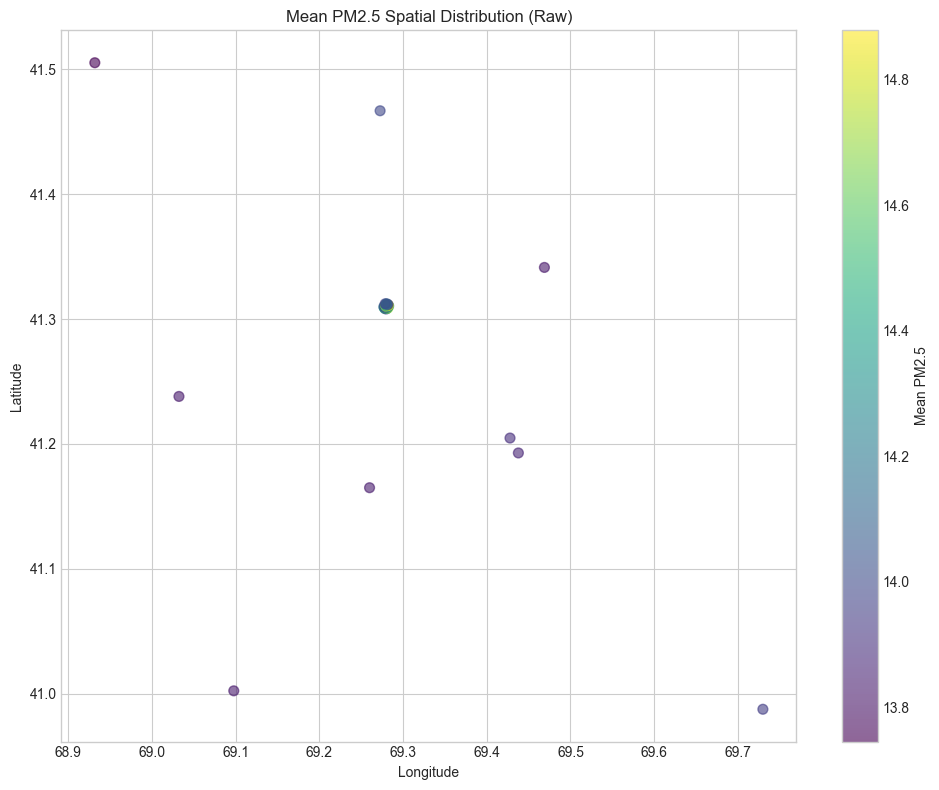

In [11]:
# Plot spatial distribution before splitting/scaling
plot_spatial_heatmap(df_featured, TARGET_COL, time_agg='mean', title="Mean PM2.5 Spatial Distribution (Raw)")

In [12]:
# 3. Split Data
df_train, df_val, df_test = split_data_temporal(df_featured, DATETIME_COL, TEST_SIZE, VALIDATION_SIZE)

Splitting data temporally...
Train period: 2023-01-01 00:00:00 to 2024-05-26 15:00:00
Validation period: 2024-05-26 16:00:00 to 2024-09-13 07:00:00
Test period: 2024-09-13 08:00:00 to 2024-12-31 23:00:00
Train shape: (736800, 26), Val shape: (157920, 26), Test shape: (157920, 26)


In [13]:
# 4. Scale Features (Fit on Train Only!)
df_train, df_val, df_test, scaler = scale_features(df_train.copy(), df_val.copy(), df_test.copy(), TARGET_COL)
exclude_from_features = [TARGET_COL, DATETIME_COL] + TIME_FEATURES_EXTRACTED
feature_cols_model = [col for col in df_train.columns if col not in exclude_from_features and '_lag_' not in col and '_roll_' not in col]
#  Add lagged/rolled features
lag_roll_cols = [col for col in df_train.columns if '_lag_' in col or '_roll_' in col]
feature_cols_model.extend(lag_roll_cols)
feature_cols_model = list(set(feature_cols_model)) 

# Check if features exist
feature_cols_model = [f for f in feature_cols_model if f in df_train.columns]
print(f"\nFeatures used for modeling: {feature_cols_model}")

X_train = df_train[feature_cols_model]
y_train = df_train[TARGET_COL]
X_val = df_val[feature_cols_model]
y_val = df_val[TARGET_COL]
X_test = df_test[feature_cols_model]
y_test = df_test[TARGET_COL] 


Scaling features...
Scaled columns: ['PM2.5_roll_mean_6h', 'day_cos', 'latitude', 'PM2.5_roll_std_12h', 'day_sin', 'longitude', 'hour_cos', 'PM2.5_lag_4h', 'PM2.5_lag_1h', 'PM2.5_lag_3h', 'PM2.5_roll_std_6h', 'PM2.5_lag_2h', 'PM2.5_lag_5h', 'month_cos', 'PM2.5_roll_mean_3h', 'hour_sin', 'PM2.5_roll_std_3h', 'month_sin', 'PM2.5_roll_mean_12h']

Features used for modeling: ['PM2.5_roll_mean_6h', 'day_cos', 'latitude', 'PM2.5_roll_std_12h', 'day_sin', 'longitude', 'hour_cos', 'PM2.5_lag_4h', 'PM2.5_lag_1h', 'PM2.5_lag_3h', 'PM2.5_roll_std_6h', 'PM2.5_lag_2h', 'spatial_cluster', 'PM2.5_lag_5h', 'month_cos', 'PM2.5_roll_mean_3h', 'hour_sin', 'PM2.5_roll_std_3h', 'month_sin', 'PM2.5_roll_mean_12h']



--- Training LightGBM Model ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's l1: 1.71018
LightGBM training complete.

--- Evaluating LightGBM Model ---
LightGBM Test MAE: 7.5472
LightGBM Test RMSE: 11.2083
Saved prediction plot to LightGBM_prediction_sample.png


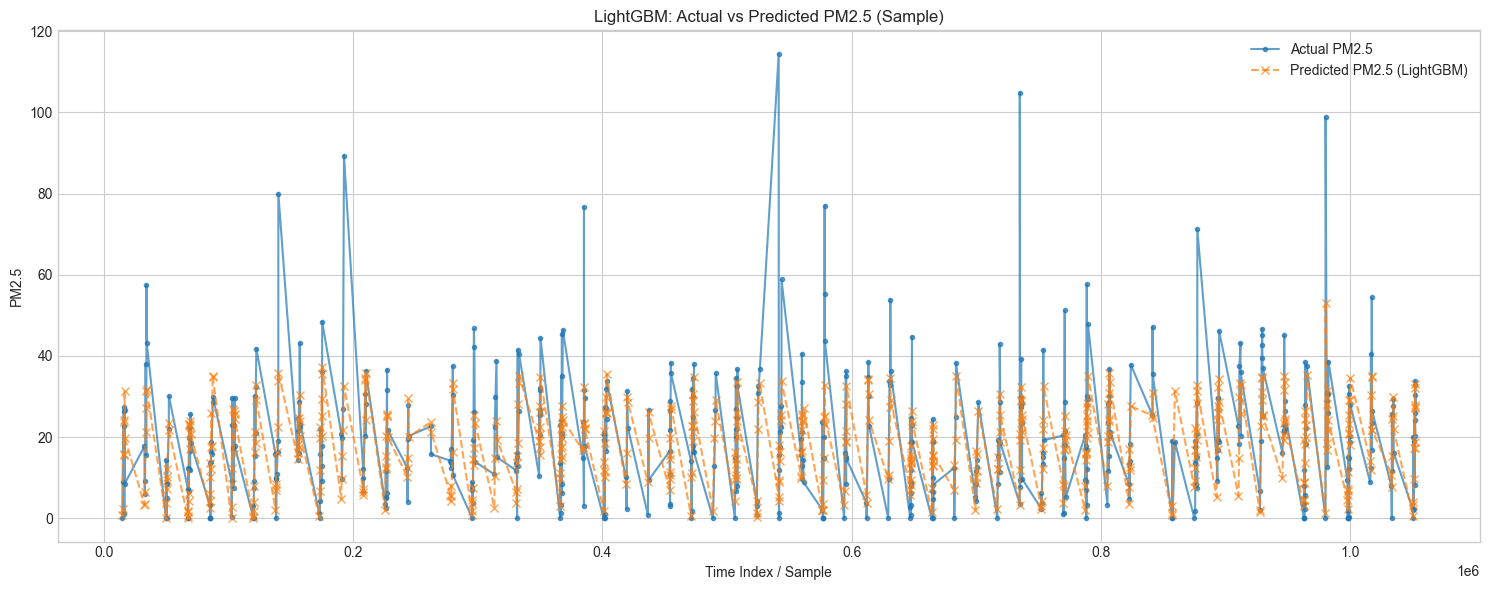

Saved feature importance plot to LightGBM_feature_importance.png


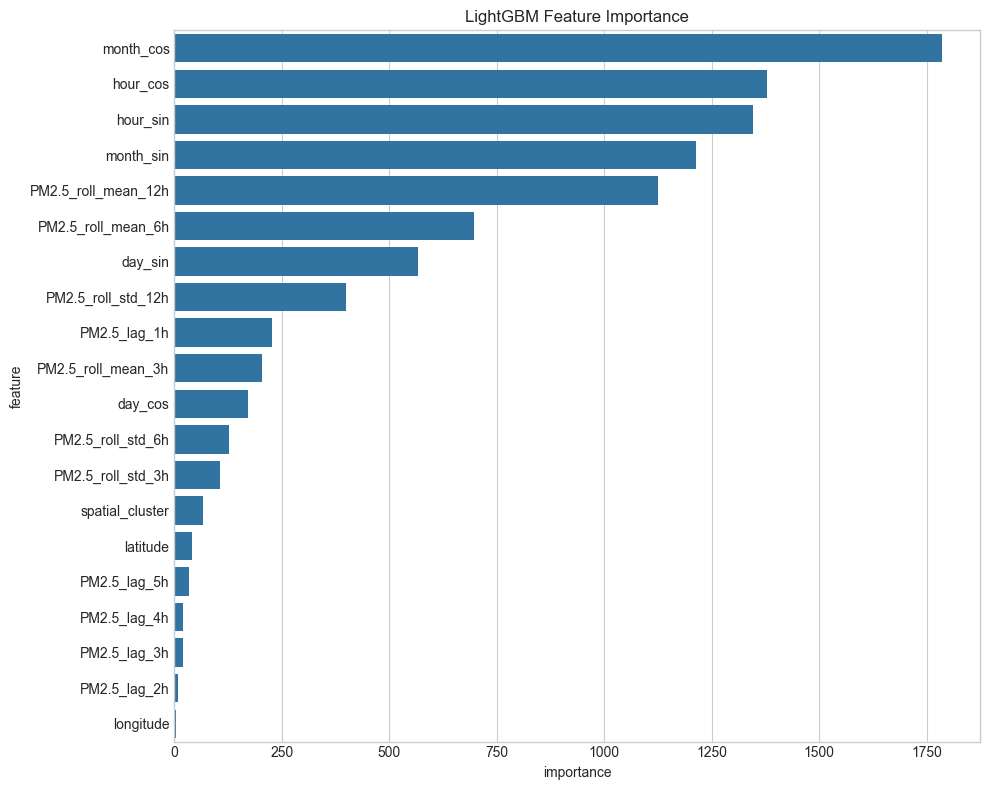

In [14]:
# --- LightGBM ---
lgbm_categorical_cols = list(X_train.select_dtypes(include='category').columns)
lgbm_model = train_lgbm(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy(), lgbm_categorical_cols)
y_pred_lgbm, mae_lgbm, rmse_lgbm = evaluate_model(lgbm_model, X_test.copy(), y_test, "LightGBM")
plot_predictions(y_test, y_pred_lgbm, "LightGBM")
plot_feature_importance(lgbm_model, X_train.columns, "LightGBM")



--- Model Option 1(b): XGBoost ---

--- Training XGBoost Model ---
[0]	validation_0-mae:14.34843
[100]	validation_0-mae:6.21790
[200]	validation_0-mae:3.68920
[300]	validation_0-mae:2.88750
[400]	validation_0-mae:2.61137
[500]	validation_0-mae:2.51326
[600]	validation_0-mae:2.48988
[700]	validation_0-mae:2.48100
[800]	validation_0-mae:2.47834
[900]	validation_0-mae:2.47974
[949]	validation_0-mae:2.47923
XGBoost training complete.

--- Evaluating XGBoost Model ---
XGBoost Test MAE: 7.6243
XGBoost Test RMSE: 10.8837
Saved prediction plot to XGBoost_prediction_sample.png


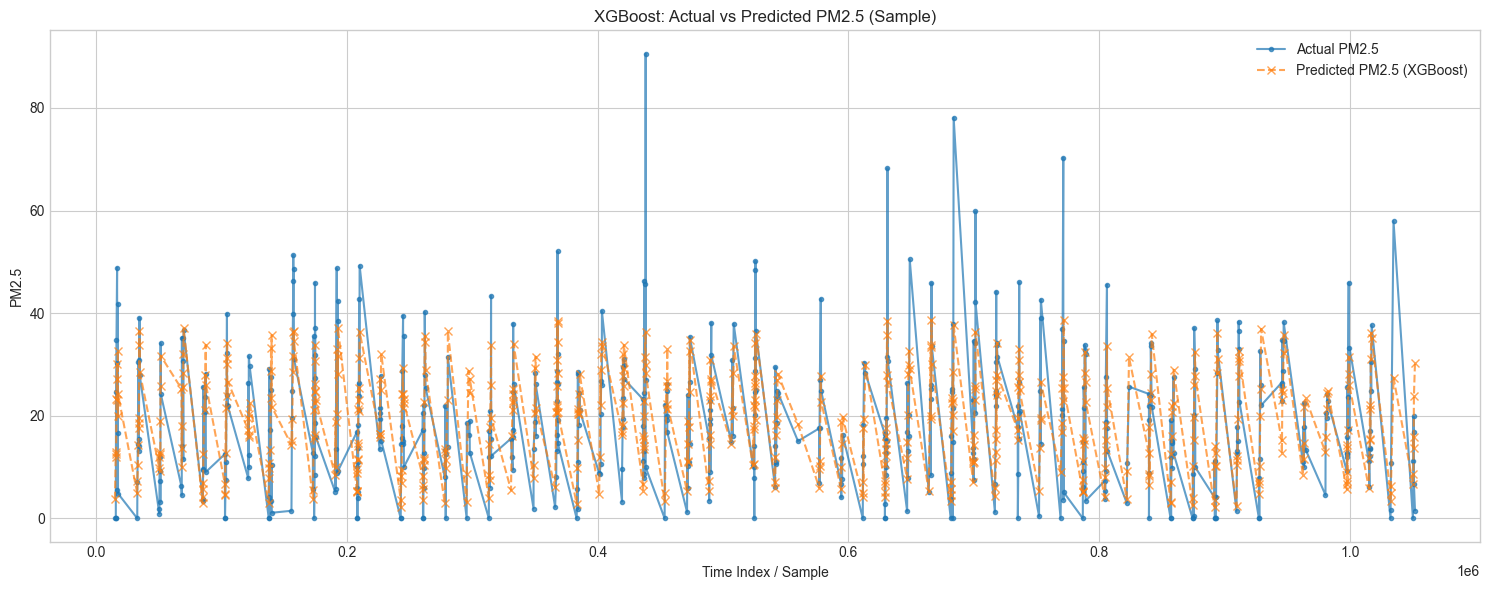

Saved feature importance plot to XGBoost_feature_importance.png


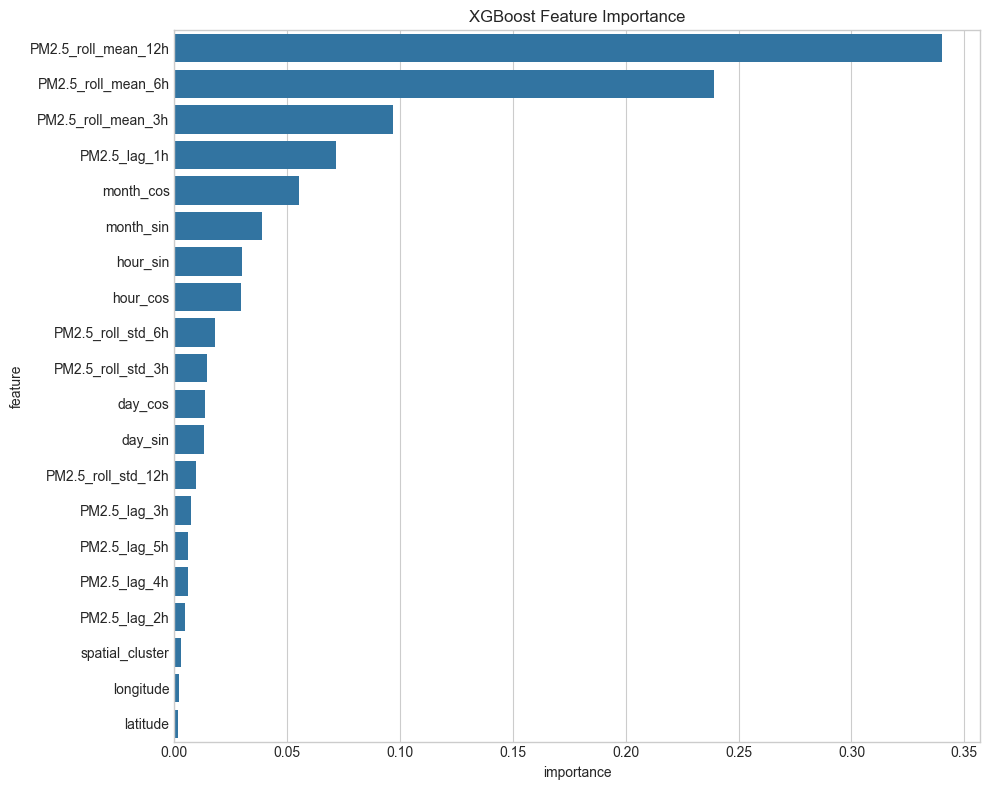

In [15]:
# --- XGBoost ---
print("\n--- Model Option 1(b): XGBoost ---")
xgb_model = train_xgboost(X_train.copy(), y_train.copy(), X_val.copy(), y_val)
y_pred_xgb, mae_xgb, rmse_xgb = evaluate_model(xgb_model, X_test.copy(), y_test, "XGBoost")
plot_predictions(y_test, y_pred_xgb, "XGBoost")
plot_feature_importance(xgb_model, X_train.columns, "XGBoost")


In [ ]:
# # --- Model Option 2: LSTM ---
# print("\nPreparing data for LSTM...")
# feature_cols_lstm = [col for col in df_train.columns if col not in [TARGET_COL, DATETIME_COL]]
# feature_cols_lstm = [f for f in feature_cols_lstm if f in df_train.columns] # Ensure existence

# # Create sequences using the *scaled* dataframes
# X_train_seq, y_train_seq = create_sequences(df_train, TARGET_COL, feature_cols_lstm, SEQ_LENGTH)
# X_val_seq, y_val_seq = create_sequences(df_val, TARGET_COL, feature_cols_lstm, SEQ_LENGTH)
# X_test_seq, y_test_seq = create_sequences(df_test, TARGET_COL, feature_cols_lstm, SEQ_LENGTH)

# # Create PyTorch DataLoaders
# train_dataset = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
# val_dataset = TensorDataset(torch.from_numpy(X_val_seq), torch.from_numpy(y_val_seq))
# test_dataset = TensorDataset(torch.from_numpy(X_test_seq), torch.from_numpy(y_test_seq))

# train_loader = DataLoader(train_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False)

# # Initialize and Train LSTM
# input_size = X_train_seq.shape[2] # Number of features
# output_size = 1 # Predict single value (PM2.5)
# lstm_model = LSTMForecaster(input_size, LSTM_HIDDEN_SIZE, LSTM_NUM_LAYERS, output_size, LSTM_DROPOUT)
# lstm_model = train_lstm(lstm_model, train_loader, val_loader, LSTM_EPOCHS, LSTM_LEARNING_RATE, DEVICE)

# # Evaluate LSTM
# y_pred_lstm, y_actual_lstm, mae_lstm, rmse_lstm = evaluate_lstm(lstm_model, test_loader, DEVICE) # Pass target scaler if needed
# # Plotting LSTM requires using y_actual_lstm (targets corresponding to sequences)
# plot_predictions(y_actual_lstm, y_pred_lstm, "LSTM")



# print("\n--- Pipeline Finished ---")